Archivo input: (Si se ejecuta la celda se obtiene el grafo "grafo_prendas.gexf")

In [1]:
import os
import torch
import requests
import networkx as nx
import pandas as pd
import numpy as np
import torch_geometric.transforms as T
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Iniciando proceso en: {device}")
url = "https://raw.githubusercontent.com/naaiaafernaandez/Reto_10_Azul_Oscuro/main/grafo_prendas.gexf"
archivo_local = "grafo_prendas.gexf"

if os.path.exists(archivo_local):
    os.remove(archivo_local)
    print(f"Archivo anterior eliminado.")

print(f"Descargando grafo...")
response = requests.get(url)
if response.status_code == 200:
    with open(archivo_local, 'wb') as f:
        f.write(response.content)
    print("Descarga completada.")
else:
    raise Exception(f"Error descarga: {response.status_code}")

try:
    G_nx = nx.read_gexf(archivo_local)
    print(f"Grafo cargado: {len(G_nx.nodes)} nodos, {len(G_nx.edges)} aristas")
    df_nodes = pd.DataFrame.from_dict(dict(G_nx.nodes(data=True)), orient='index')
    df_nodes = df_nodes.fillna('Desconocido')
    
    node_features = pd.DataFrame(index=df_nodes.index)
    for col in df_nodes.columns:
        if df_nodes[col].dtype == 'object':
            le = LabelEncoder()
            node_features[col] = le.fit_transform(df_nodes[col].astype(str))
        else:
            node_features[col] = df_nodes[col]
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(node_features.values)
    x = torch.tensor(features_scaled, dtype=torch.float)
    
    temp_data = from_networkx(G_nx)
    data = Data(x=x, edge_index=temp_data.edge_index.long(), num_nodes=len(G_nx.nodes))
    
    transform = T.RandomLinkSplit(
        num_val=0.1,
        num_test=0.1,
        is_undirected=True,
        add_negative_train_samples=False
    )
    train_data, val_data, test_data = transform(data)
    
    train_data = train_data.to(device)
    val_data = val_data.to(device)
    test_data = test_data.to(device)
    
    print("Datos procesados y divididos correctamente.")
    print(f"   - Features: {data.num_features}")
    print(f"   - Train Edges: {train_data.edge_label_index.shape[1]}")

except Exception as e:
    print(f"Error procesando el grafo: {e}")

c:\Users\lande\anaconda3\envs\r10_lookiero\lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: C:\Users\lande\anaconda3\envs\r10_lookiero\Lib\site-packages\torch_scatter\_version_cpu.pyd
  import torch_geometric.typing
c:\Users\lande\anaconda3\envs\r10_lookiero\lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not load this library: C:\Users\lande\anaconda3\envs\r10_lookiero\Lib\site-packages\torch_cluster\_version_cpu.pyd
  import torch_geometric.typing
c:\Users\lande\anaconda3\envs\r10_lookiero\lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: Could not load this library: C:\Users\lande\anaconda3\envs\r10_lookiero\Lib\site-packages\torch_spline_conv\_version_cpu.py

Iniciando proceso en: cpu
Archivo anterior eliminado.
Descargando grafo...
Descarga completada.
Grafo cargado: 7555 nodos, 1140880 aristas
Datos procesados y divididos correctamente.
   - Features: 14
   - Train Edges: 912704


In [ ]:
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score

class NetGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

model = NetGCN(in_channels=data.num_features, hidden_channels=128, out_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

print("Entrenando GCN (300 épocas)...")

for epoch in range(1, 301):
    model.train()
    optimizer.zero_grad()
    
    z = model.encode(train_data.x, train_data.edge_index)
    neg_edge_index = negative_sampling(train_data.edge_index, num_nodes=train_data.num_nodes, num_neg_samples=train_data.edge_label_index.size(1), method='sparse')
    
    edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data.edge_label, train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0).float()
    
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            z = model.encode(val_data.x, val_data.edge_index)
            out = model.decode(z, val_data.edge_label_index).view(-1).sigmoid()
            auc = roc_auc_score(val_data.edge_label.cpu(), out.cpu())
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {auc:.4f}")

torch.save(model.state_dict(), 'Modelos/modelo_gnn_final.pth')
print("GCN Guardado exitosamente.")

🏁 Entrenando GCN (300 épocas)...
Epoch: 020, Loss: 0.4975, Val AUC: 0.9365
Epoch: 040, Loss: 0.4826, Val AUC: 0.9407
Epoch: 060, Loss: 0.4694, Val AUC: 0.9509
Epoch: 080, Loss: 0.4560, Val AUC: 0.9563
Epoch: 100, Loss: 0.4520, Val AUC: 0.9613
Epoch: 120, Loss: 0.4487, Val AUC: 0.9617
Epoch: 140, Loss: 0.4465, Val AUC: 0.9652
Epoch: 160, Loss: 0.4448, Val AUC: 0.9670
Epoch: 180, Loss: 0.4437, Val AUC: 0.9672
Epoch: 200, Loss: 0.4418, Val AUC: 0.9686
Epoch: 220, Loss: 0.4371, Val AUC: 0.9729
Epoch: 240, Loss: 0.4352, Val AUC: 0.9743
Epoch: 260, Loss: 0.4355, Val AUC: 0.9738
Epoch: 280, Loss: 0.4327, Val AUC: 0.9741
Epoch: 300, Loss: 0.4323, Val AUC: 0.9744
💾 GCN Guardado exitosamente.


📊 Generando Gráficas para GCN...


C:\Users\carlo\AppData\Local\Temp\ipykernel_6540\493807430.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('modelo_gnn_final.pth', map_l

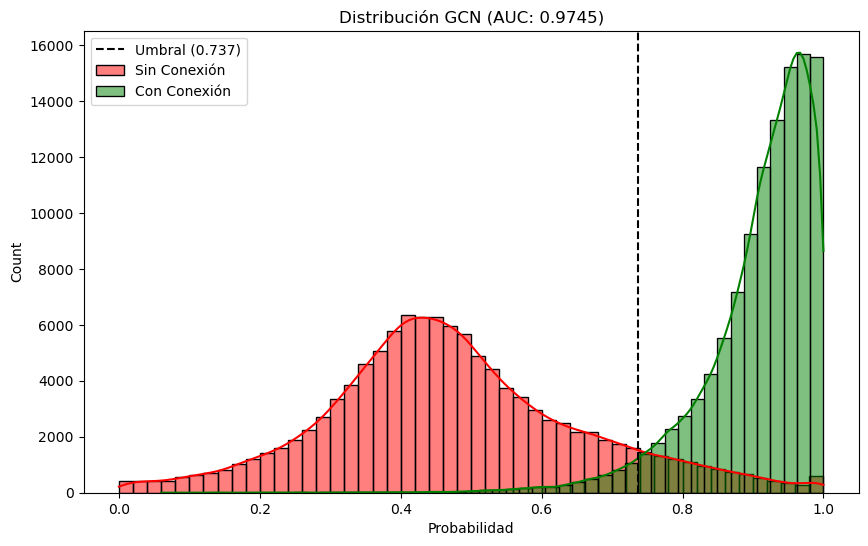

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve

print("Generando Gráficas para GCN...")
model = NetGCN(in_channels=data.num_features, hidden_channels=128, out_channels=64).to(device)
model.load_state_dict(torch.load('Modelos/modelo_gnn_final.pth', map_location=device))
model.eval()

with torch.no_grad():
    z = model.encode(test_data.x, test_data.edge_index)
    out = model.decode(z, test_data.edge_label_index).view(-1).sigmoid()
    y_true = test_data.edge_label.cpu().numpy()
    y_scores = out.cpu().numpy()

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
best_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall + 1e-10))]

plt.figure(figsize=(10, 6))
preds_pos = y_scores[y_true == 1]
preds_neg = y_scores[y_true == 0]
sns.histplot(preds_neg, color='red', alpha=0.5, label='Sin Conexión', bins=50, kde=True)
sns.histplot(preds_pos, color='green', alpha=0.5, label='Con Conexión', bins=50, kde=True)
plt.axvline(x=best_threshold, color='black', linestyle='--', label=f'Umbral ({best_threshold:.3f})')
plt.title(f'Distribución GCN (AUC: {roc_auc:.4f})')
plt.xlabel('Probabilidad'); plt.legend(); plt.show()

In [ ]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class NetGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=2, concat=True, dropout=0.1)
        self.conv2 = GATConv(hidden_channels * 2, out_channels, heads=1, concat=False, dropout=0.1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

model = NetGAT(in_channels=data.num_features, hidden_channels=64, out_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCEWithLogitsLoss()

print("Entrenando GAT (300 épocas)...")

for epoch in range(1, 301):
    model.train()
    optimizer.zero_grad()
    
    z = model.encode(train_data.x, train_data.edge_index)
    neg_edge_index = negative_sampling(train_data.edge_index, num_nodes=train_data.num_nodes, num_neg_samples=train_data.edge_label_index.size(1), method='sparse')
    
    edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data.edge_label, train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0).float()
    
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            z = model.encode(val_data.x, val_data.edge_index)
            out = model.decode(z, val_data.edge_label_index).view(-1).sigmoid()
            auc = roc_auc_score(val_data.edge_label.cpu(), out.cpu())
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {auc:.4f}")

torch.save(model.state_dict(), 'Modelos/modelo_gat_final.pth')
print("GAT Guardado exitosamente.")

🏁 Entrenando GAT (300 épocas)...
Epoch: 020, Loss: 0.5502, Val AUC: 0.8782
Epoch: 040, Loss: 0.5277, Val AUC: 0.8917
Epoch: 060, Loss: 0.5193, Val AUC: 0.9001
Epoch: 080, Loss: 0.5135, Val AUC: 0.9067
Epoch: 100, Loss: 0.5098, Val AUC: 0.9113
Epoch: 120, Loss: 0.5062, Val AUC: 0.9149
Epoch: 140, Loss: 0.5028, Val AUC: 0.9193
Epoch: 160, Loss: 0.4975, Val AUC: 0.9238
Epoch: 180, Loss: 0.4930, Val AUC: 0.9282
Epoch: 200, Loss: 0.4895, Val AUC: 0.9317
Epoch: 220, Loss: 0.4864, Val AUC: 0.9344
Epoch: 240, Loss: 0.4839, Val AUC: 0.9362
Epoch: 260, Loss: 0.4817, Val AUC: 0.9386
Epoch: 280, Loss: 0.4796, Val AUC: 0.9412
Epoch: 300, Loss: 0.4766, Val AUC: 0.9429
💾 GAT Guardado exitosamente.


📊 Generando Gráficas para GAT...


C:\Users\carlo\AppData\Local\Temp\ipykernel_6540\291833452.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('modelo_gat_final.pth', map_l

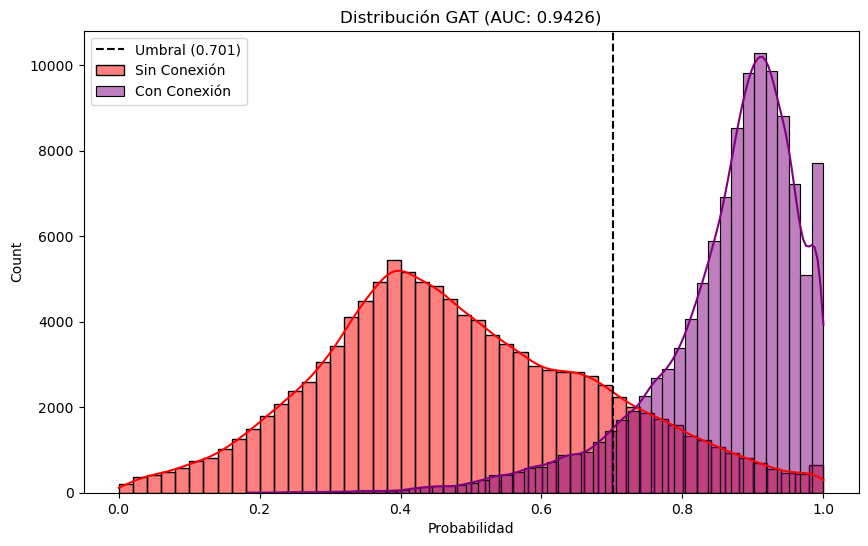

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve # Re-importamos para arreglar el error

print("Generando Gráficas para GAT...")
model = NetGAT(in_channels=data.num_features, hidden_channels=64, out_channels=64).to(device)
model.load_state_dict(torch.load('Modelos/modelo_gat_final.pth', map_location=device))
model.eval()

with torch.no_grad():
    z = model.encode(test_data.x, test_data.edge_index)
    out = model.decode(z, test_data.edge_label_index).view(-1).sigmoid()
    y_true = test_data.edge_label.cpu().numpy()
    y_scores = out.cpu().numpy()

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
best_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall + 1e-10))]

plt.figure(figsize=(10, 6))
preds_pos = y_scores[y_true == 1]
preds_neg = y_scores[y_true == 0]
sns.histplot(preds_neg, color='red', alpha=0.5, label='Sin Conexión', bins=50, kde=True)
sns.histplot(preds_pos, color='purple', alpha=0.5, label='Con Conexión', bins=50, kde=True)
plt.axvline(x=best_threshold, color='black', linestyle='--', label=f'Umbral ({best_threshold:.3f})')
plt.title(f'Distribución GAT (AUC: {roc_auc:.4f})')
plt.xlabel('Probabilidad'); plt.legend(); plt.show()

In [ ]:
from torch_geometric.nn import SAGEConv

class NetSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr='mean')
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr='mean')

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

model = NetSAGE(in_channels=data.num_features, hidden_channels=128, out_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

print("Entrenando GraphSAGE (300 épocas)...")

for epoch in range(1, 301):
    model.train()
    optimizer.zero_grad()
    
    z = model.encode(train_data.x, train_data.edge_index)
    neg_edge_index = negative_sampling(train_data.edge_index, num_nodes=train_data.num_nodes, num_neg_samples=train_data.edge_label_index.size(1), method='sparse')
    
    edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data.edge_label, train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0).float()
    
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            z = model.encode(val_data.x, val_data.edge_index)
            out = model.decode(z, val_data.edge_label_index).view(-1).sigmoid()
            val_auc = roc_auc_score(val_data.edge_label.cpu(), out.cpu())
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}")

torch.save(model.state_dict(), 'Modelos/modelo_sage_final.pth')
print("GraphSAGE Guardado exitosamente.")

🏁 Entrenando GraphSAGE (300 épocas)...
Epoch: 020, Loss: 0.7494, Val AUC: 0.5733
Epoch: 040, Loss: 0.6328, Val AUC: 0.8045
Epoch: 060, Loss: 0.5787, Val AUC: 0.8401
Epoch: 080, Loss: 0.5597, Val AUC: 0.8681
Epoch: 100, Loss: 0.5462, Val AUC: 0.8862
Epoch: 120, Loss: 0.5359, Val AUC: 0.9102
Epoch: 140, Loss: 0.5249, Val AUC: 0.9263
Epoch: 160, Loss: 0.5175, Val AUC: 0.9331
Epoch: 180, Loss: 0.5140, Val AUC: 0.9370
Epoch: 200, Loss: 0.5078, Val AUC: 0.9436
Epoch: 220, Loss: 0.5001, Val AUC: 0.9477
Epoch: 240, Loss: 0.4939, Val AUC: 0.9481
Epoch: 260, Loss: 0.4889, Val AUC: 0.9535
Epoch: 280, Loss: 0.4850, Val AUC: 0.9539
Epoch: 300, Loss: 0.4828, Val AUC: 0.9554
💾 GraphSAGE Guardado exitosamente.


📊 Generando Gráficas para GraphSAGE...


C:\Users\carlo\AppData\Local\Temp\ipykernel_6540\3968662859.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('modelo_sage_final.pth', map

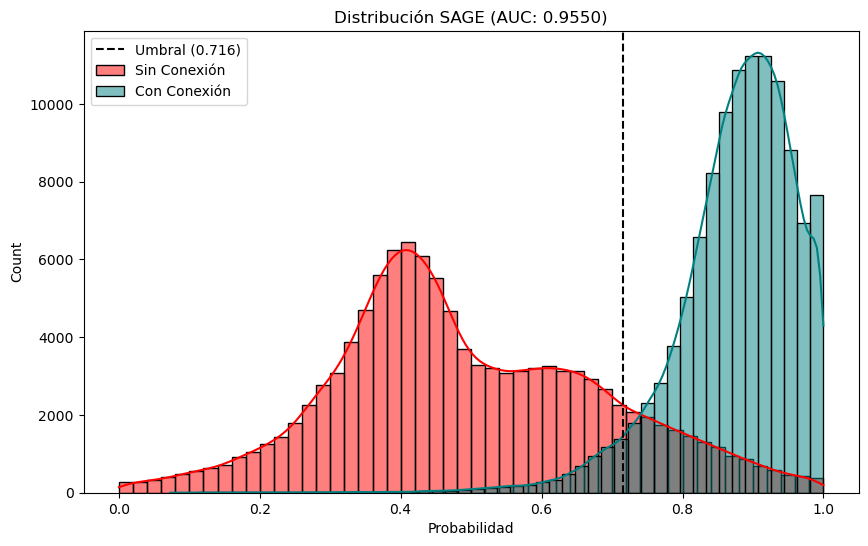

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve # Re-import por seguridad

print("Generando Gráficas para GraphSAGE...")
model = NetSAGE(in_channels=data.num_features, hidden_channels=128, out_channels=64).to(device)
model.load_state_dict(torch.load('Modelos/modelo_sage_final.pth', map_location=device))
model.eval()

with torch.no_grad():
    z = model.encode(test_data.x, test_data.edge_index)
    out = model.decode(z, test_data.edge_label_index).view(-1).sigmoid()
    y_true = test_data.edge_label.cpu().numpy()
    y_scores = out.cpu().numpy()

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
best_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall + 1e-10))]

plt.figure(figsize=(10, 6))
preds_pos = y_scores[y_true == 1]
preds_neg = y_scores[y_true == 0]
sns.histplot(preds_neg, color='red', alpha=0.5, label='Sin Conexión', bins=50, kde=True)
sns.histplot(preds_pos, color='teal', alpha=0.5, label='Con Conexión', bins=50, kde=True)
plt.axvline(x=best_threshold, color='black', linestyle='--', label=f'Umbral ({best_threshold:.3f})')
plt.title(f'Distribución SAGE (AUC: {roc_auc:.4f})')
plt.xlabel('Probabilidad'); plt.legend(); plt.show()

📊 GENERANDO COMPARATIVA FINAL...


C:\Users\carlo\AppData\Local\Temp\ipykernel_6540\2775755731.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))

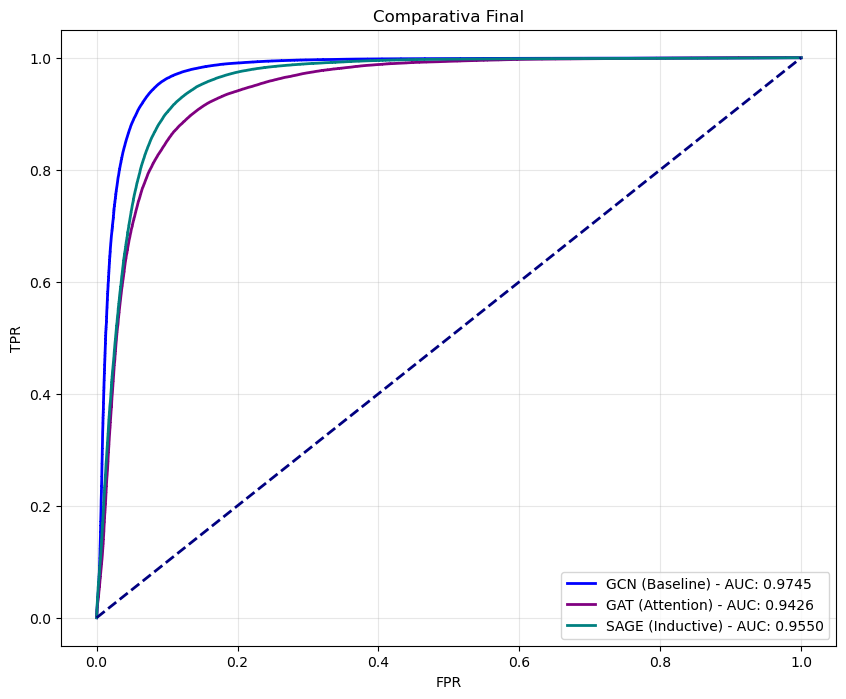

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
colors = {'GCN (Baseline)': 'blue', 'GAT (Attention)': 'purple', 'SAGE (Inductive)': 'teal'}
test_data = test_data.to(device)

modelos_a_comparar = [
    ("GCN (Baseline)", NetGCN, 'Modelos/modelo_gnn_final.pth', {'hidden_channels': 128}),
    ("GAT (Attention)", NetGAT, 'Modelos/modelo_gat_final.pth', {'hidden_channels': 64}), 
    ("SAGE (Inductive)", NetSAGE, 'Modelos/modelo_sage_final.pth', {'hidden_channels': 128})
]

print("GENERANDO COMPARATIVA FINAL...")

for name, cls, path, args in modelos_a_comparar:
    try:
        model = cls(in_channels=data.num_features, out_channels=64, **args).to(device)
        model.load_state_dict(torch.load(path, map_location=device))
        model.eval()
        
        with torch.no_grad():
            z = model.encode(test_data.x, test_data.edge_index)
            out = model.decode(z, test_data.edge_label_index).view(-1).sigmoid()
            fpr, tpr, _ = roc_curve(test_data.edge_label.cpu().numpy(), out.cpu().numpy())
            score = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=colors[name], lw=2, label=f'{name} - AUC: {score:.4f}')
            
    except Exception as e:
        print(f"Error en {name}: {e}")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Comparativa Final')
plt.legend(loc="lower right"); plt.grid(alpha=0.3); plt.show()

GCN con 1000 epocas+scheduler

In [ ]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score

class NetGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

model = NetGCN(in_channels=data.num_features, hidden_channels=128, out_channels=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, min_lr=0.00001)
criterion = torch.nn.BCEWithLogitsLoss()

print("Entrenando GCN 'Prueba 1' (1000 épocas con LR adaptativo)...")

for epoch in range(1, 1001): 
    model.train()
    optimizer.zero_grad()
    
    z = model.encode(train_data.x, train_data.edge_index)
    neg_edge_index = negative_sampling(train_data.edge_index, num_nodes=train_data.num_nodes, num_neg_samples=train_data.edge_label_index.size(1), method='sparse')
    
    edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data.edge_label, train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0).float()
    
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            z = model.encode(val_data.x, val_data.edge_index)
            out = model.decode(z, val_data.edge_label_index).view(-1).sigmoid()
            auc = roc_auc_score(val_data.edge_label.cpu(), out.cpu())
            
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch: {epoch:04d}, Loss: {loss:.5f}, Val AUC: {auc:.5f} | LR: {current_lr:.6f}")

torch.save(model.state_dict(), 'Modelos/gcn_prueba1.pth')
print("Modelo guardado como: gcn_prueba1.pth")

🏁 Entrenando GCN 'Prueba 1' (1000 épocas con LR adaptativo)...
Epoch: 0020, Loss: 0.49982, Val AUC: 0.93157 | LR: 0.010000
Epoch: 0040, Loss: 0.48334, Val AUC: 0.93948 | LR: 0.010000
Epoch: 0060, Loss: 0.46822, Val AUC: 0.95088 | LR: 0.010000
Epoch: 0080, Loss: 0.45695, Val AUC: 0.95085 | LR: 0.010000
Epoch: 0100, Loss: 0.45331, Val AUC: 0.95906 | LR: 0.010000
Epoch: 0120, Loss: 0.45047, Val AUC: 0.96193 | LR: 0.010000
Epoch: 0140, Loss: 0.44807, Val AUC: 0.96355 | LR: 0.010000
Epoch: 0160, Loss: 0.44621, Val AUC: 0.96686 | LR: 0.010000
Epoch: 0180, Loss: 0.44310, Val AUC: 0.96786 | LR: 0.010000
Epoch: 0200, Loss: 0.44362, Val AUC: 0.96924 | LR: 0.010000
Epoch: 0220, Loss: 0.43729, Val AUC: 0.97143 | LR: 0.010000
Epoch: 0240, Loss: 0.43592, Val AUC: 0.97322 | LR: 0.010000
Epoch: 0260, Loss: 0.43684, Val AUC: 0.97390 | LR: 0.010000
Epoch: 0280, Loss: 0.43334, Val AUC: 0.97474 | LR: 0.010000
Epoch: 0300, Loss: 0.43310, Val AUC: 0.97464 | LR: 0.010000
Epoch: 0320, Loss: 0.43248, Val AUC: 

📊 Visualizando resultados de: gcn_prueba1.pth


C:\Users\carlo\AppData\Local\Temp\ipykernel_6540\1697369981.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('gcn_prueba1.pth', map_locat

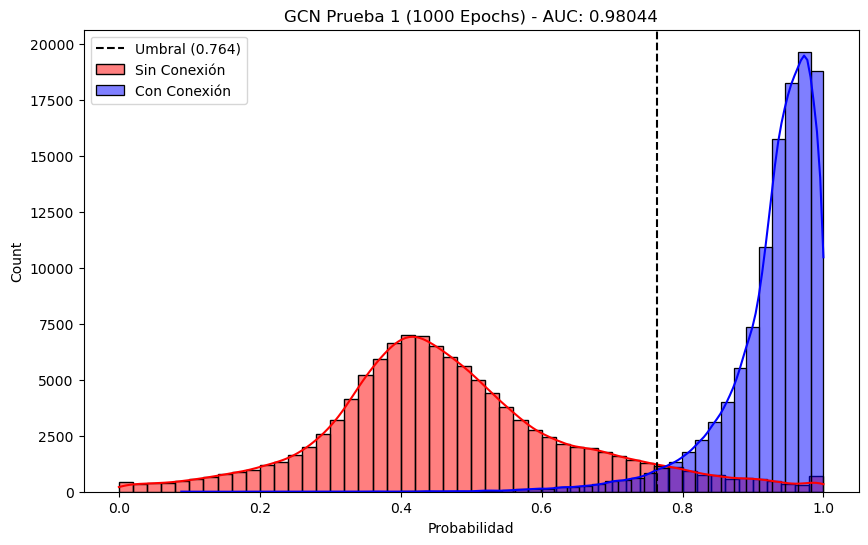

🔹 Accuracy Final: 0.94668


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve

print("Visualizando resultados de: gcn_prueba1.pth")

model = NetGCN(in_channels=data.num_features, hidden_channels=128, out_channels=64).to(device)
model.load_state_dict(torch.load('Modelos/gcn_prueba1.pth', map_location=device))
model.eval()

with torch.no_grad():
    z = model.encode(test_data.x, test_data.edge_index)
    out = model.decode(z, test_data.edge_label_index).view(-1).sigmoid()
    y_true = test_data.edge_label.cpu().numpy()
    y_scores = out.cpu().numpy()

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
best_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall + 1e-10))]

plt.figure(figsize=(10, 6))
preds_pos = y_scores[y_true == 1]
preds_neg = y_scores[y_true == 0]

sns.histplot(preds_neg, color='red', alpha=0.5, label='Sin Conexión', bins=50, kde=True)
sns.histplot(preds_pos, color='blue', alpha=0.5, label='Con Conexión', bins=50, kde=True)
plt.axvline(x=best_threshold, color='black', linestyle='--', label=f'Umbral ({best_threshold:.3f})')

plt.title(f'GCN Prueba 1 (1000 Epochs) - AUC: {roc_auc:.5f}')
plt.xlabel('Probabilidad')
plt.legend()
plt.show()

preds_opt = (y_scores > best_threshold).astype(int)
acc_opt = (preds_opt == y_true).sum() / len(y_true)
print(f"🔹Accuracy Final: {acc_opt:.5f}")